In [69]:
import sys
import logging
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from scipy.fftpack import fft, ifft, fftfreq
import matplotlib.pyplot as plt

In [70]:
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.models.bimamba import CoherentBiMamba

In [71]:
plt.style.use('seaborn-v0_8-darkgrid')
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

In [ ]:
# Constants
BAUD_RATE = 32e9
LAMBDA_NM = 1550.0
FIBER_LENGTH_KM = 100.0
C_MPS = 299792458

# QPSK Symbol Map
SYMBOL_MAP = np.array([1+1j, -1+1j, -1-1j, 1-1j])

def apply_chromatic_dispersion(signal, cd_value=20.0):
    n = len(signal)
    freqs = fftfreq(n, d=1/BAUD_RATE)
    constant_factor = (np.pi * (LAMBDA_NM * 1e-9)**2 * FIBER_LENGTH_KM * 1e3) / C_MPS
    phase_factor = constant_factor * cd_value * 1e-12
    transfer_func = np.exp(-1j * phase_factor * (freqs**2))
    return ifft(fft(signal) * transfer_func)

def apply_phase_noise(signal, linewidth_rate=1e-5, rng=None):
    if rng is None: rng = np.random.default_rng()
    phase_steps = rng.normal(0, np.sqrt(2 * np.pi * linewidth_rate), size=len(signal))
    return signal * np.exp(1j * np.cumsum(phase_steps))

def apply_awgn(signal, snr_db=20.0, rng=None):
    if rng is None: rng = np.random.default_rng()
    sig_power = np.mean(np.abs(signal)**2)
    noise_power = sig_power / (10**(snr_db / 10))
    noise = np.sqrt(noise_power/2) * (rng.standard_normal(len(signal)) + 1j * rng.standard_normal(len(signal)))
    return signal + noise

In [73]:
# Hamming (7,4) Matrices
G_sys = np.array([[1,0,0,0,1,1,0], [0,1,0,0,1,0,1], [0,0,1,0,0,1,1], [0,0,0,1,1,1,1]], dtype=int)
H_sys = np.array([[1,1,0,1,1,0,0], [1,0,1,1,0,1,0], [0,1,1,1,0,0,1]], dtype=int)

def encode_sys(data_bits):
    return (data_bits.reshape(-1, 4).dot(G_sys) % 2).flatten()

def decode_sys_vectorized(rx_bits):
    blocks = rx_bits.reshape(-1, 7)
    s_int = (blocks.dot(H_sys.T) % 2).dot(np.array([4, 2, 1]))
    lookup = np.array([-1, 6, 5, 2, 4, 1, 0, 3]) # Maps syndrome to error index
    cols_to_flip = lookup[s_int]
    err_indices = np.where(cols_to_flip != -1)[0]
    if len(err_indices) > 0:
        blocks[err_indices, cols_to_flip[err_indices]] ^= 1
    return blocks[:, :4].flatten()

class MatrixInterleaver:
    def __init__(self, depth=14):
        self.depth = depth 
        
    def interleave(self, bits):
        n = len(bits)
        # Ensure divisible by depth AND even (for QPSK)
        target_align = self.depth * 2 if self.depth % 2 != 0 else self.depth
        pad_len = (target_align - (n % target_align)) % target_align
        bits_padded = np.pad(bits, (0, pad_len), constant_values=0)
        
        rows = len(bits_padded) // self.depth
        return bits_padded.reshape(rows, self.depth).T.flatten(), n

    def deinterleave(self, bits, original_length):
        rows = len(bits) // self.depth
        matrix = bits.reshape(self.depth, rows).T
        return matrix.flatten()[:original_length]

In [74]:
# Loading the checkpoint from Epoch 14 (Curriculum Stage: High CD).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoherentBiMamba(num_classes=4, in_channels=2, d_model=64, num_layers=4).to(device)

ckpt_path = project_root / "experiments/logs/bimamba_curriculum/model_epoch_14.pt"
if ckpt_path.exists():
    print(f"Loading checkpoint: {ckpt_path}")
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
else:
    print("Warning: Checkpoint not found.")

Loading checkpoint: /home/cowen/mamba-optical-spectra/experiments/logs/bimamba_curriculum/model_epoch_14.pt


/tmp/ipykernel_282319/4099901642.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


In [ ]:
# Simulate a transmission of 100k bits with CD=20.0 and Phase Noise=1e-5.
# 1. Configuration
N_BITS = 50000
CD_VAL = 20.0
LINEWIDTH = 1e-5
SNR_DB = 20.0
INTERLEAVER_DEPTH = 42
SEQ_LEN = 1024

rng = np.random.default_rng(42)

# 2. Generate Data
print("Generating Data...")
tx_bits = rng.integers(0, 2, size=N_BITS)
encoded_bits = encode_sys(tx_bits)

# Interleave
interleaver = MatrixInterleaver(depth=INTERLEAVER_DEPTH)
tx_bits_intl, orig_len = interleaver.interleave(encoded_bits)

Generating Data...


In [89]:
# Modulate
def bits_to_symbols(bits):
    indices = bits.reshape(-1, 2).dot(np.array([2, 1]))
    return SYMBOL_MAP[indices], indices

tx_symbols, tx_indices = bits_to_symbols(tx_bits_intl)

In [ ]:
# 3. Channel Simulation (BLOCK-WISE)
# Process physics in 1024-symbol chunks to reset phase drift,
# matching exactly how the model was trained/validated.

# Pad to multiple of SEQ_LEN
n_syms = len(tx_symbols)
n_batches = int(np.ceil(n_syms / SEQ_LEN))
pad_len = n_batches * SEQ_LEN - n_syms
tx_padded = np.pad(tx_symbols, (0, pad_len), constant_values=0)

rx_batch_list = []

print(f"Applying Channel (Block-Wise): CD={CD_VAL}, LW={LINEWIDTH}, SNR={SNR_DB}dB")

for i in range(n_batches):
    # Extract clean chunk
    sig_chunk = tx_padded[i*SEQ_LEN : (i+1)*SEQ_LEN]
    
    # Apply Physics LOCALLY (Resets phase/CD per block)
    sig_chunk = apply_chromatic_dispersion(sig_chunk, cd_value=CD_VAL)
    sig_chunk = apply_phase_noise(sig_chunk, linewidth_rate=1e-5, rng=rng)
    sig_chunk = apply_awgn(sig_chunk, snr_db=SNR_DB, rng=rng)
    
    rx_batch_list.append(sig_chunk)

Applying Channel (Block-Wise): CD=20.0, LW=1e-05, SNR=20.0dB


In [100]:
# 4. Prepare Tensor
rx_complex = np.array(rx_batch_list) # Shape: [Batches, SEQ_LEN]

# Stack Real/Imag
rx_tensor = torch.tensor(
    np.stack([rx_complex.real, rx_complex.imag], axis=1), 
    dtype=torch.float32
) # Shape: [B, 2, L]

# We calculate stats across the entire [2, L] block, not per channel.
# This prevents "Independent Component" centering which artificially cleans the signal.

# Flatten (B, 2, L) -> (B, 2*L) to get global mean/std per batch
flat_view = rx_tensor.view(rx_tensor.size(0), -1)

means = flat_view.mean(dim=1).view(-1, 1, 1)
stds = flat_view.std(dim=1).view(-1, 1, 1) + 1e-8

inputs = (rx_tensor - means) / stds

In [101]:
# 5. Inference
print("Running Inference...")
model.eval()
with torch.inference_mode():
    logits = model(inputs.to(device)) 
    preds = logits.max(1)[1].cpu().numpy().flatten()
    all_preds = preds[:len(tx_symbols)] # Trim padding

Running Inference...


In [102]:
# 6. Decode & BER
print("Decoding...")
def symbols_to_bits_vectorized(indices):
    return np.column_stack([(indices >> 1) & 1, indices & 1]).flatten()

rx_bits_scrambled = symbols_to_bits_vectorized(all_preds)
rx_bits_raw = interleaver.deinterleave(rx_bits_scrambled, orig_len)
rx_data = decode_sys_vectorized(rx_bits_raw)

# Calculate BER
pre_fec_ber = np.mean(rx_bits_raw != encoded_bits)
post_fec_ber = np.mean(rx_data != tx_bits)
bit_errors = np.sum(rx_data != tx_bits)

print("-" * 30)
print(f"Pre-FEC BER:      {pre_fec_ber:.5e}")
print(f"Post-FEC BER:     {post_fec_ber:.5e}")
print(f"Total Bit Errors: {bit_errors}")
print("-" * 30)

Decoding...
------------------------------
Pre-FEC BER:      0.00000e+00
Post-FEC BER:     0.00000e+00
Total Bit Errors: 0
------------------------------


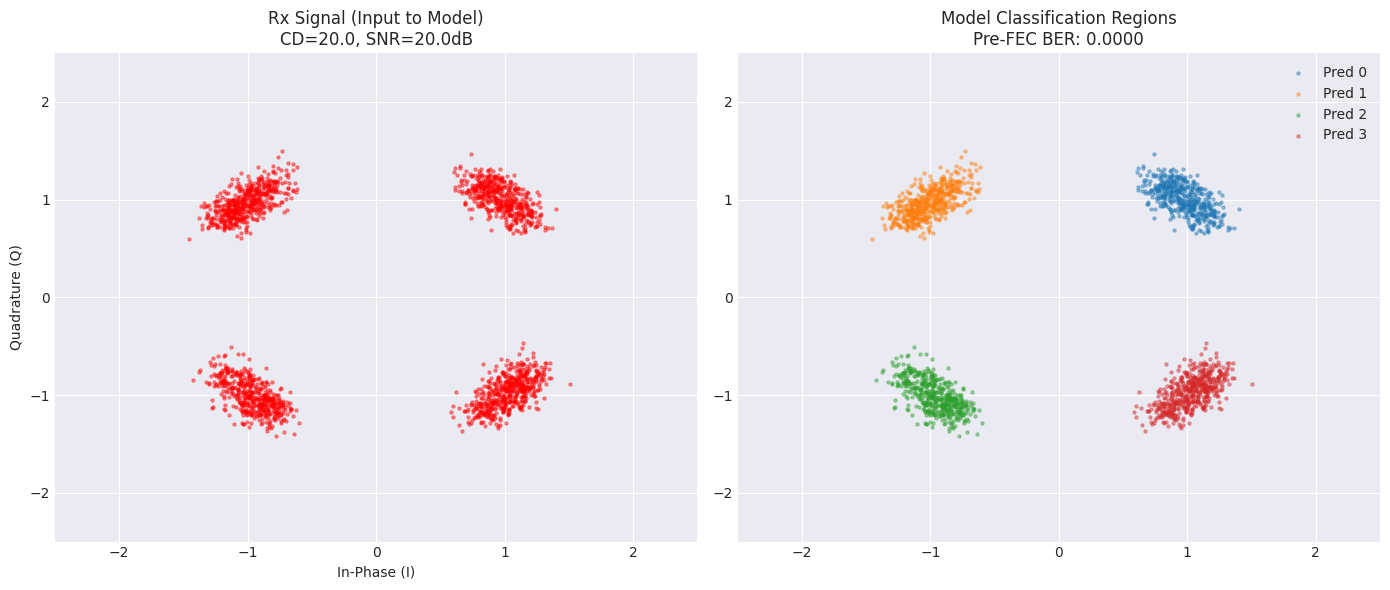

In [103]:
# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Flatten the complex batches to get a single stream for plotting
rx_flat = rx_complex.flatten() 

# Plot 1: Received Signal (Before Model)
# Take the first 2000 symbols
batch_0 = rx_flat[:2000] 

axes[0].scatter(batch_0.real, batch_0.imag, s=5, alpha=0.4, c='red')
axes[0].set_title(f"Rx Signal (Input to Model)\nCD={CD_VAL}, SNR={SNR_DB}dB")
axes[0].set_xlim(-2.5, 2.5); axes[0].set_ylim(-2.5, 2.5)
axes[0].set_xlabel("In-Phase (I)"); axes[0].set_ylabel("Quadrature (Q)")

# Plot 2: Model Decision Space
# Visualize confusion by coloring the Rx signal by the Model's prediction
colors = ['blue', 'green', 'orange', 'purple']
pred_batch = all_preds[:2000]

for i in range(4):
    mask = (pred_batch == i)
    axes[1].scatter(batch_0.real[mask], batch_0.imag[mask], s=5, alpha=0.4, label=f"Pred {i}")

axes[1].set_title(f"Model Classification Regions\nPre-FEC BER: {pre_fec_ber:.4f}")
axes[1].set_xlim(-2.5, 2.5); axes[1].set_ylim(-2.5, 2.5)
axes[1].legend()

plt.tight_layout()
plt.savefig("bimamba_results_showcase.png", dpi=150)
plt.show()